# **Práctica 5: Puntos de interés**

<img src ="https://epigijon.uniovi.es/image/image_gallery?uuid=903ae5c8-b29b-430e-980d-1a19a885c736&groupId=3743853&t=1688576582973" width=300 px>

Este cuaderno desarrolla contenidos prácticos de la asignatura **Visión artificial** del Grado en Ciencia e Ingeniería de Datos.

***

# Características

La extracción de características en imágenes es un paso crucial en el procesamiento de imágenes y visión por computador. Uno de los tipos de características que se pueden extraer son las esquinas. Las esquinas son puntos distintivos en una imagen que son útiles para tareas como el reconocimiento de objetos, el seguimiento de objetos en movimiento y la reconstrucción tridimensional.

Existen varios algoritmos para la extracción de características. Uno de los más conocidos es el algoritmo Harris Corner Detector. La idea central del detector de Harris es que las esquinas se encuentran en regiones de la imagen donde hay una alta variación en la intensidad en varias direcciones.

> Implementa una función que calcule la función de respuesta de Harris: `def compute_harris_response(im, sigma=3, k=0.04)`

El algoritmo debe realizar las siguientes tareas:

> Determina el gradiente en la dirección vertical y horizontal ($G_x$ y $G_y$) usan el operador FDoG (derivada de la Gaussiana). Recuerda que la función gaussian_filter necesita la imagen representada como número real entre 0 y 1.

> Determina $G_{xx}= (Gx)^2$, $G_{yy} = (Gy)^2$ y $G_{xy} = GxGy$. Suaviza el resultado de estas operaciones según el valor de sigma que se recibe por parámetro.

> Calcula la función de respuesta como $R = det - k * (tr^2)$, donde $det = G_{xx}*G_{yy} - (G_{xy})^2$ y $tr = G_{xx} + G_{yy}$

> Visualiza el resultado para la siguiente imagen de ejemplo


In [3]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def compute_harris_response(img, sigma=3, k=0.04):
    # Calcula los gradientes en las direcciones X e Y usando FDoG
    Gx = gaussian_filter(img, sigma=sigma, order=[0, 1])
    Gy = gaussian_filter(img, sigma=sigma, order=[1, 0])
    
    # Calcula los elementos de la matriz de estructura
    Gxx = gaussian_filter(Gx**2, sigma)
    Gyy = gaussian_filter(Gy**2, sigma)
    Gxy = gaussian_filter(Gx*Gy, sigma)
    
    # Determinante y traza de la matriz de estructura
    det = Gxx * Gyy - Gxy**2
    trace = Gxx + Gyy
    
    # Cálculo de la función de respuesta de Harris
    R = det - k * (trace**2)
    
    return R



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  114k  100  114k    0     0   353k      0 --:--:-- --:--:-- --:--:--  359k


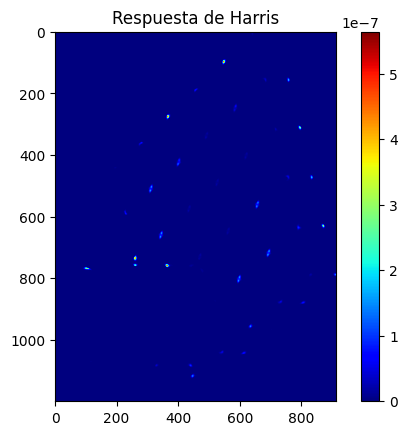

In [4]:
!curl http://www.atc.uniovi.es/grado/3va/prac/checkershadow.png -o checkershadow.png
import skimage

# Cargar imagen y convertir a escala de grises si es necesario
img = skimage.io.imread("checkershadow.png")
if img.ndim == 3:  
    img = skimage.color.rgb2gray(img)

img = img.astype(np.float32)  

# Computar respuesta de Harris
R = compute_harris_response(img)
checkershadow = np.stack(R, axis=-1)
checkershadow = np.clip(checkershadow, 0, 1)  

# Visualizar el resultado
plt.imshow(checkershadow, cmap="jet")
plt.colorbar()
plt.title("Respuesta de Harris")
plt.show()


Para determinar la posición de las esquinas hay que buscar los máximos locales en la respuesta. En primer lugar se puede realizar una umbralización:


(7126, 2)


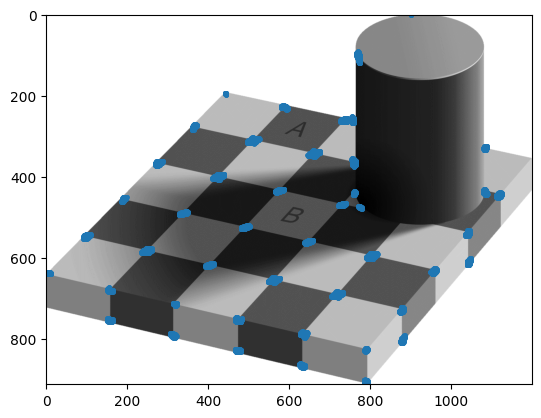

In [5]:
threshold = 0.01
esquinas = np.argwhere(R > threshold * R.max())
print(esquinas.shape)

plt.imshow(img, cmap='gray')
esquinas = np.array(esquinas)
plt.plot(esquinas[:, 1], esquinas[:, 0], '.', markersize=5)
plt.show()

Para una determinada esquina, se obtienen muchos puntos. Para resolver ese problema se debe implementar la función de supresión de no-máximos. La función de supresión de no-máximos, también conocida como NMS (por sus siglas en inglés, Non-Maximum Suppression), es comúnmente utilizada en tareas de detección de objetos en imágenes o vídeos. Su propósito es reducir la redundancia en las detecciones al eliminar las detecciones que se superponen significativamente y retener solo la detección con más confianza, en este caso con mayor valor de la función de respuesta.

> Implementa la función `non_max_suppression(corners, R, distance_threshold)`

El algoritmo debe realizar lo siguiente:

> Ordenar las esquinas por el valor de respuesta: `corners = sorted(corners, key=lambda x: R[x[0], x[1]], reverse=True)`

> Para cada esquina, en orden decreciente de respuesta

> Determinar la distancia a todas las esquinas seleccionadas: `distances = [np.linalg.norm(np.array(corner) - np.array(selected)) for selected in selected_corners]`. Inicialmente `selected_corners` es una lista vacía.

> Si no hay elementos dentro de la distancia seleccionada (`np.count_nonzero(np.array(distances) < distance_threshold) == 0`) se añade a la lista de esquinas seleccionadas. El valor de `distance_threshold` se debe elegir como la distancia mínima admitibles entre dos esquinas diferentes.

> Se retornan las esquinas seleccionadas




In [1]:
def non_max_suppression(corners, R, distance_threshold):
    
    corners = sorted(corners, key=lambda x: R[x[0], x[1]], reverse=True)
    
    selected_corners = []
    
    for corner in corners:
        distances = [np.linalg.norm(np.array(corner) - np.array(selected)) for selected in selected_corners]
        if np.count_nonzero(np.array(distances) < distance_threshold) == 0:
            selected_corners.append(corner)
    
    return selected_corners

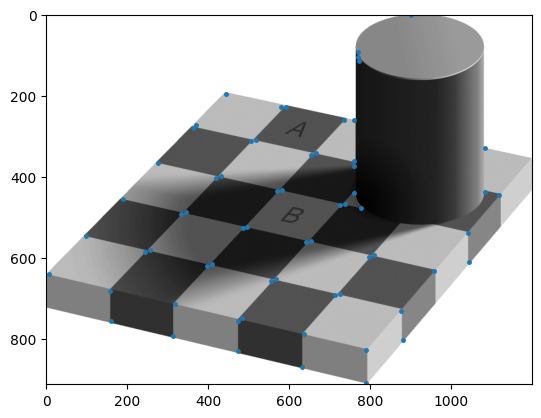

In [6]:
plt.imshow(img, cmap='gray')
esquinas=non_max_suppression(esquinas,R,12)

esquinas = np.array(esquinas)

plt.plot(esquinas[:, 1], esquinas[:, 0], '.', markersize=5)
plt.show()

Las esquinas son consideradas características de interés debido a su invariancia a la rotación y escala, estabilidad estructural, capacidad discriminativa y eficiencia computacional. Estas propiedades únicas hacen que las esquinas destaquen en la detección, seguimiento y reconocimiento de patrones en imágenes, ya que conservan su forma y estructura a través de diferentes orientaciones y escalas, ofrecen estabilidad en regiones con cambios bruscos de intensidad, y son eficientes en términos de procesamiento, siendo esenciales en aplicaciones como la reconstrucción 3D, la realidad aumentada y la identificación de objetos.

> Realiza la detección de esquinas en las siguientes dos imágenes y visualiza los resultados

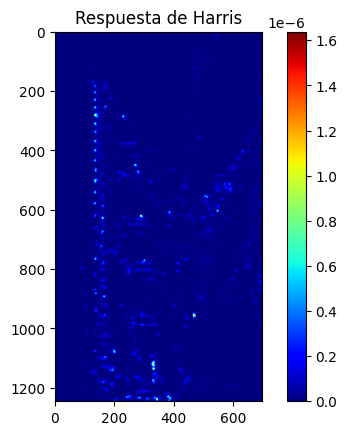

(90493, 2)


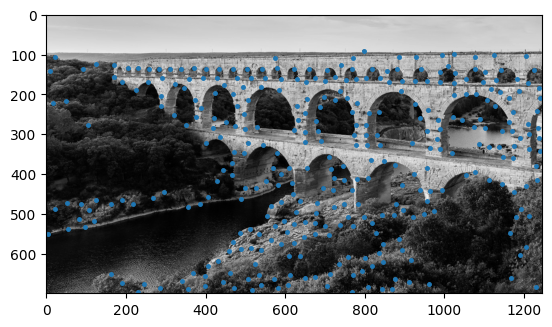

In [7]:
# Cargar imagen y convertir a escala de grises si es necesario
img = skimage.io.imread("s1.jpg")
if img.ndim == 3:  # Si la imagen tiene 3 canales (RGB)
    img = skimage.color.rgb2gray(img)

img = img.astype(np.float32)  # Asegurar que sea de tipo float32

# Computar respuesta de Harris
R = compute_harris_response(img)
s1 = np.stack(R, axis=-1)
s1 = np.clip(s1, 0, 1)  # Asegurar valores en el rango correcto

# Visualizar el resultado
plt.imshow(s1, cmap="jet")
plt.colorbar()
plt.title("Respuesta de Harris")
plt.show()

threshold = 0.01
esquinas = np.argwhere(R > threshold * R.max())
print(esquinas.shape)

plt.imshow(img, cmap='gray')
esquinas=non_max_suppression(esquinas,R,25)

esquinas = np.array(esquinas)

plt.plot(esquinas[:, 1], esquinas[:, 0], '.', markersize=5)
plt.show()

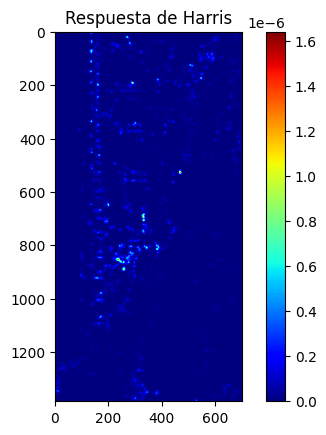

(114138, 2)


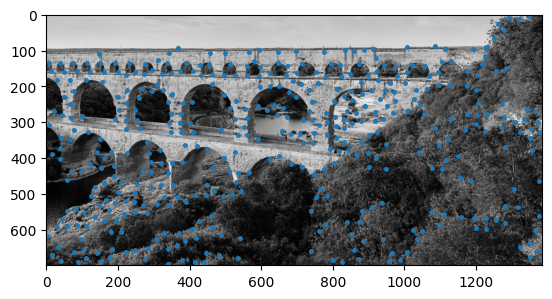

In [8]:
# Cargar imagen y convertir a escala de grises si es necesario
img = skimage.io.imread("s2.jpg")
if img.ndim == 3:  # Si la imagen tiene 3 canales (RGB)
    img = skimage.color.rgb2gray(img)

img = img.astype(np.float32)  # Asegurar que sea de tipo float32

# Computar respuesta de Harris
R = compute_harris_response(img)
s2 = np.stack(R, axis=-1)
s2 = np.clip(s2, 0, 1)  # Asegurar valores en el rango correcto

# Visualizar el resultado
plt.imshow(s2, cmap="jet")
plt.colorbar()
plt.title("Respuesta de Harris")
plt.show()

threshold = 0.01
esquinas = np.argwhere(R > threshold * R.max())
print(esquinas.shape)

plt.imshow(img, cmap='gray')
esquinas=non_max_suppression(esquinas,R,25)

esquinas = np.array(esquinas)

plt.plot(esquinas[:, 1], esquinas[:, 0], '.', markersize=5)
plt.show()

Observa que las esquinas aparecen repetidas en ambas vistas. Idealmente esto debería permitir alinear ambas imágenes y crear una única imagen combinación de ambas.

> Implementa una función que extraiga descriptores de cada esquina. Esta función obtiene un vector con los valores de intensidad alrededor de cada coordenada de esquina. Aquellas esquinas que estén muy cerca del borde se pueden ignorar.

> Implementa una función que determine correspondencias entre los descriptores de ambas imágenes para encontrar coincidencias. Para la comparación se debe utilizar la correlación cruzada normalizada.

> Muestra las resultados utilizando la función `skimage.feature.plot_matches`

C:\Users\llano\AppData\Local\Temp\ipykernel_22976\3325148638.py:69: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  skimage.feature.plot_matches(ax, img1, img2, vld_corners1, vld_corners2, matches)


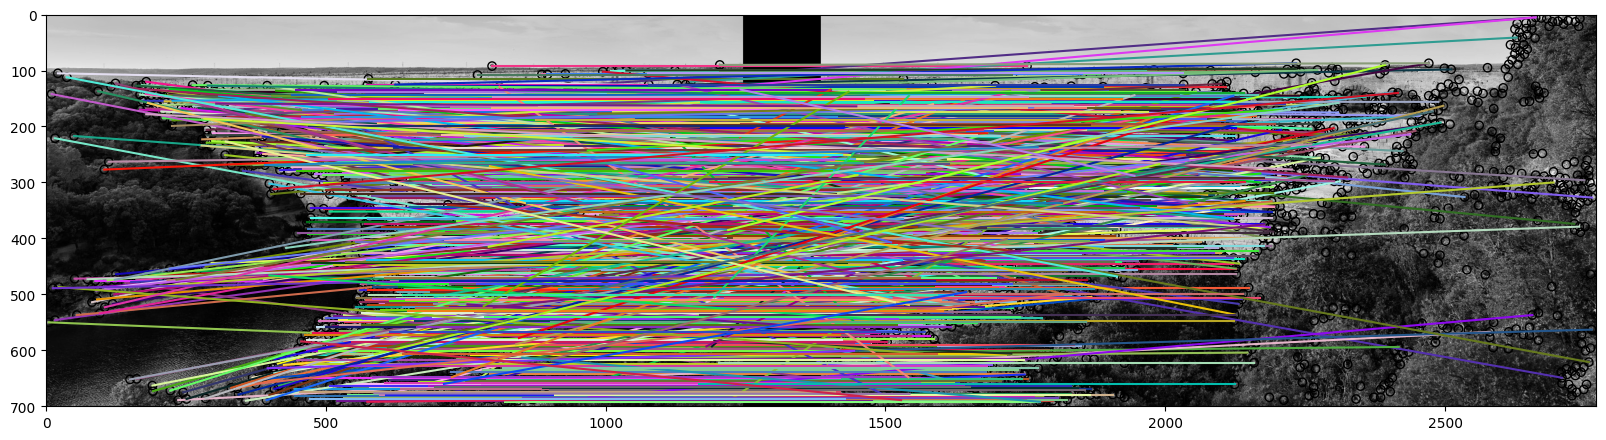

In [ ]:
import numpy as np
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

def extract_descriptors(image, corners, tam_vecindario=9):
    half_size = tam_vecindario // 2
    descriptors = []
    valid_corners = []
    for x, y in corners:
        if (x - half_size < 0 or x + half_size >= image.shape[0] or
            y - half_size < 0 or y + half_size >= image.shape[1]):
            continue  
        vecindario = image[x-half_size:x+half_size+1, y-half_size:y+half_size+1]
        descriptors.append(vecindario.flatten()) 
        valid_corners.append((x, y))

    return np.array(descriptors), valid_corners


def match_descriptors(desc1, desc2):
    matches = []
    for i, des1 in enumerate(desc1):
        best_match = -1
        best_score = -100000000

        for j, des2 in enumerate(desc2):
            # Correlación cruzada normalizada
            if np.std(des1) > 0 and np.std(des2) > 0:
                score = np.sum((des1 - des1.mean()) * (des2 - des2.mean())) / (np.std(des1) * np.std(des2) * len(des1))

                if score > best_score:
                    best_score = score
                    best_match = j

        if best_match != -1:
            matches.append((i, best_match))

    return np.array(matches)


# Cargar imágenes y convertirlas a escala de grises
img1 = skimage.color.rgb2gray(skimage.io.imread("s1.jpg"))
img2 = skimage.color.rgb2gray(skimage.io.imread("s2.jpg"))
# Detectar esquinas usando el detector de Harris
R1 = compute_harris_response(img1)
R2 = compute_harris_response(img2)
# Seleccionar esquinas con un umbral
threshold = 0.01 * max(R1.max(), R2.max())
corners1 = [(i, j) for i in range(R1.shape[0]) for j in range(R1.shape[1]) if R1[i, j] > threshold]
corners2 = [(i, j) for i in range(R2.shape[0]) for j in range(R2.shape[1]) if R2[i, j] > threshold]
# Aplicar supresión de no máximos
distance_threshold = 10
selected_corners1 = non_max_suppression(corners1, R1, distance_threshold)
selected_corners2 = non_max_suppression(corners2, R2, distance_threshold)
# Extraer descriptores
desc1, vld_corners1 = extract_descriptors(img1, selected_corners1)
desc2, vld_corners2 = extract_descriptors(img2, selected_corners2)
# Encontrar correspondencias
matches = match_descriptors(desc1, desc2)
# Convertir esquinas en formato de array
vld_corners1 = np.array(vld_corners1)
vld_corners2 = np.array(vld_corners2)
# Visualizar coincidencias
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
skimage.feature.plot_matches(ax, img1, img2, vld_corners1, vld_corners2, matches)
plt.show()


> Utiliza la función `skimage.feature.match_descriptors` y observa las diferencias.

C:\Users\llano\AppData\Local\Temp\ipykernel_22976\1042468995.py:10: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  skimage.feature.plot_matches(ax, img1, img2, valid_corners1, valid_corners2, matches)


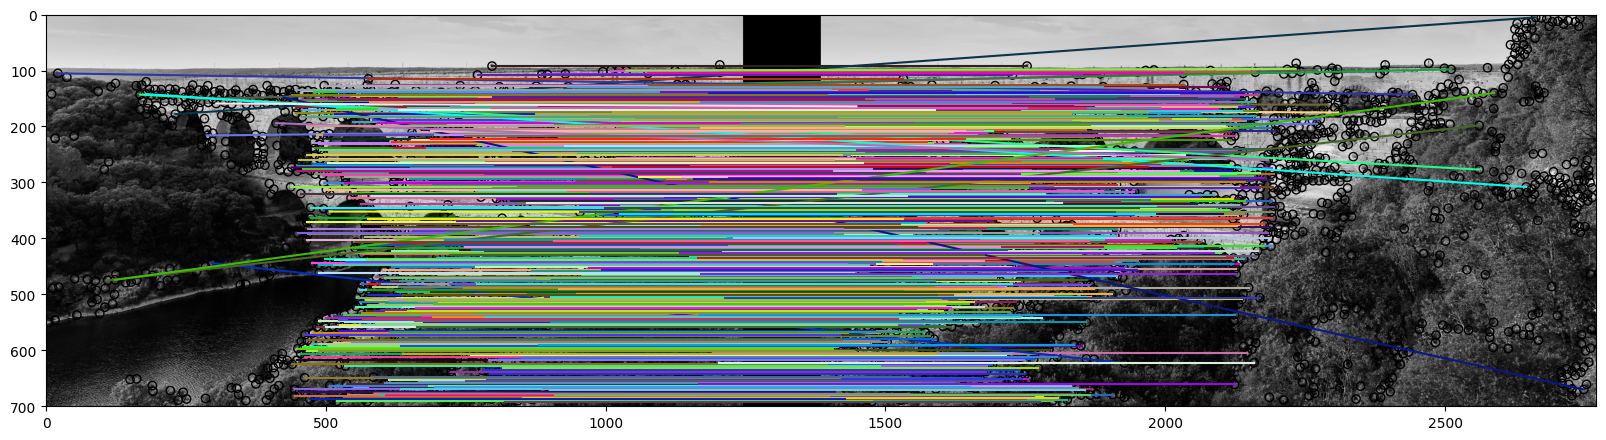

In [10]:
# Encontrar correspondencias
matches = skimage.feature.match_descriptors(desc1, desc2)

# Convertir esquinas en formato de array
valid_corners1 = np.array(vld_corners1)
valid_corners2 = np.array(vld_corners2)

# Visualizar coincidencias
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
skimage.feature.plot_matches(ax, img1, img2, valid_corners1, valid_corners2, matches)
plt.show()


> Extrae descriptores con alguna de las opciones de la biblioteca skimage, busca correspondencias y muestra los resultados.

In [ ]:
import numpy as np
import skimage.io
import skimage.color
import skimage.feature
import matplotlib.pyplot as plt

def extract_orb_descriptors(image):
    """
    Extrae características y descriptores de una imagen usando ORB.

    Parámetros:
        image: ndarray
            Imagen en escala de grises.

    Retorna:
        keypoints: ndarray
            Coordenadas (y, x) de las características detectadas.
        descriptors: ndarray
            Descriptores de las características detectadas.
    """
    orb = skimage.feature.ORB(n_keypoints=500)
    orb.detect_and_extract(image)
    return orb.keypoints, orb.descriptors

# Cargar imágenes y convertirlas a escala de grises
image1 = skimage.color.rgb2gray(skimage.io.imread("s1.jpg"))
image2 = skimage.color.rgb2gray(skimage.io.imread("s2.jpg"))

# Extraer descriptores
keypoints1, descriptors1 = extract_orb_descriptors(image1)
keypoints2, descriptors2 = extract_orb_descriptors(image2)

# Encontrar coincidencias usando Hamming (para ORB)
matches = skimage.feature.match_descriptors(descriptors1, descriptors2, cross_check=True)

# Visualizar coincidencias
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
skimage.feature.plot_matches(ax, image1, image2, keypoints1, keypoints2, matches)
plt.show()
